In [99]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

In [100]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\fake_bills.csv",sep=';')
df 

,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54
...,...,...,...,...,...,...,...
1495,False,171.75,104.38,104.17,4.42,3.09,111.28
1496,False,172.19,104.63,104.44,5.27,3.37,110.97
1497,False,171.80,104.01,104.12,5.51,3.36,111.95
1498,False,172.06,104.28,104.06,5.17,3.46,112.25


In [101]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   is_genuine    1500 non-null   bool   
 1   diagonal      1500 non-null   float64
 2   height_left   1500 non-null   float64
 3   height_right  1500 non-null   float64
 4   margin_low    1463 non-null   float64
 5   margin_up     1500 non-null   float64
 6   length        1500 non-null   float64
dtypes: bool(1), float64(6)
memory usage: 71.9 KB


In [102]:
### Tạo biến dummies
df['is_genuine'] = df['is_genuine'].replace(to_replace=[False,True],value= [0,1])

In [103]:
df['margin_low'].mode()[0]

4.08

In [104]:
df['margin_low'] =df['margin_low'].fillna(df['margin_low'].mode()[0])

In [105]:
df['margin_low'].value_counts()

margin_low
4.08    57
4.10    20
4.18    20
4.17    18
4.12    18
        ..
5.35     1
6.11     1
5.70     1
5.74     1
5.41     1
Name: count, Length: 285, dtype: int64

(array([ 500.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        1000.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

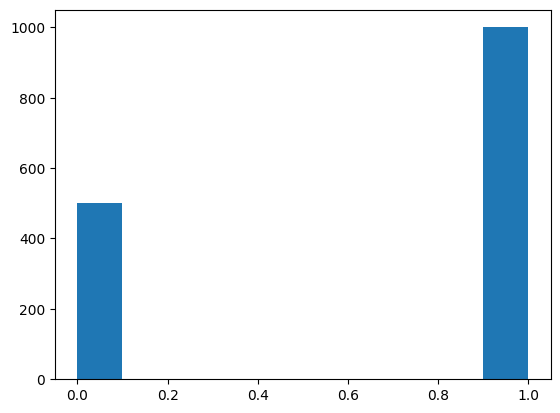

In [106]:
plt.hist(df[['is_genuine']])

## Data bị bias nên sẽ tăng số lượng lớp True để cân bằng dữ liệu khi train

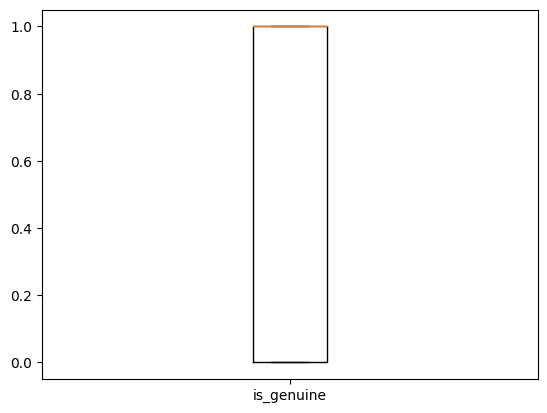

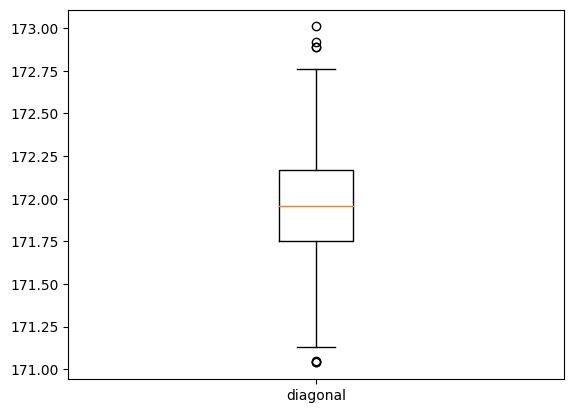

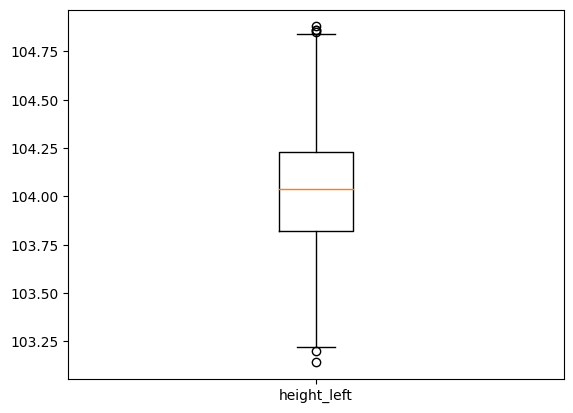

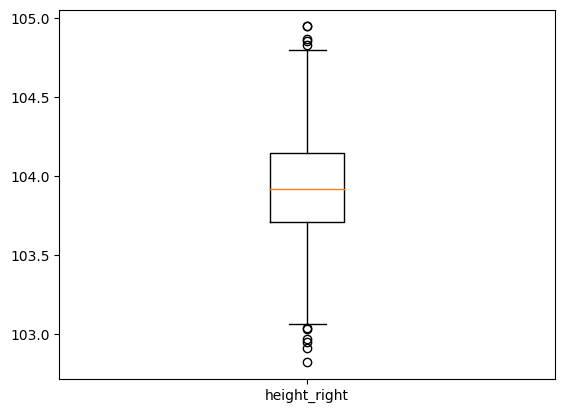

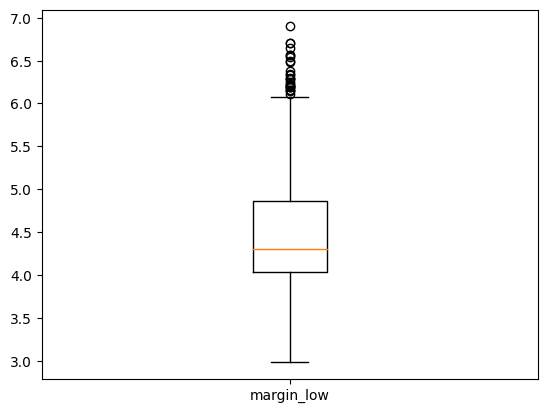

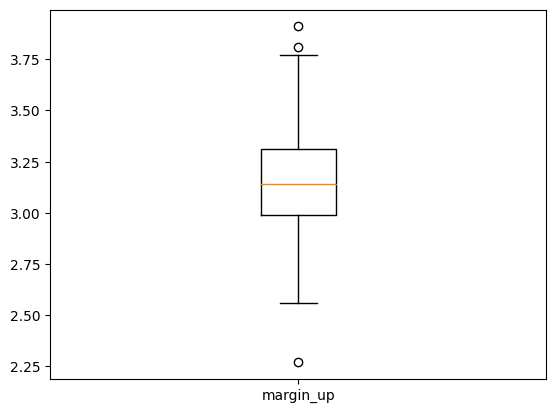

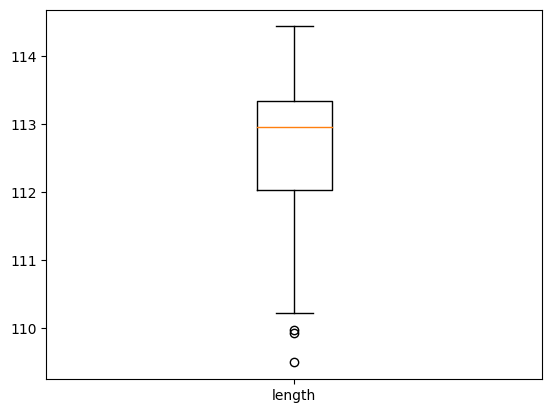

In [107]:
for i in df.columns:
    plt.boxplot(df[i],labels=[i])
    plt.show()

### Vì đặc trưng của dataset gồm chiều cao, chiều rộng của tiền giả nên không loại bỏ outlier

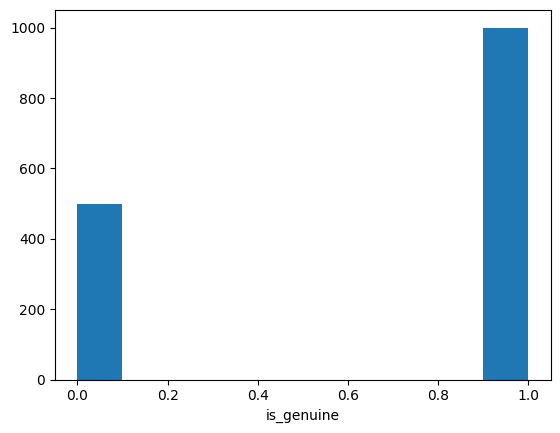

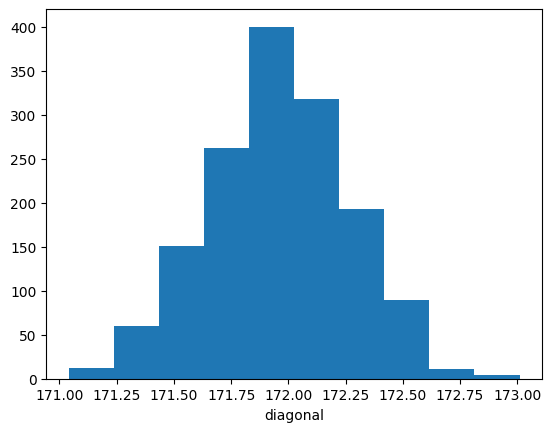

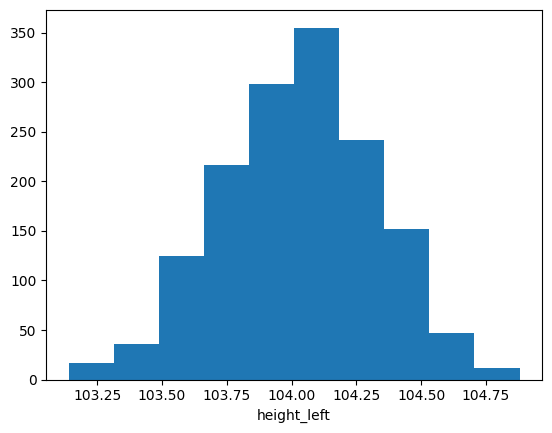

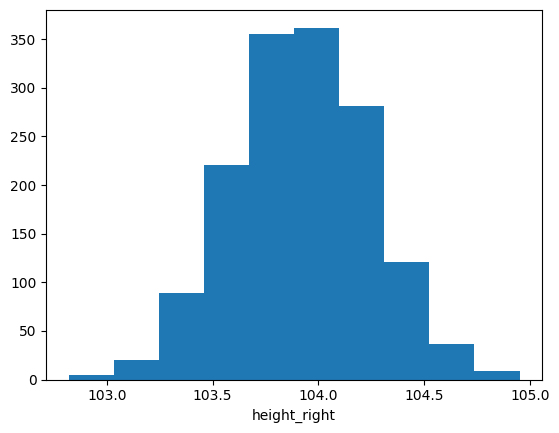

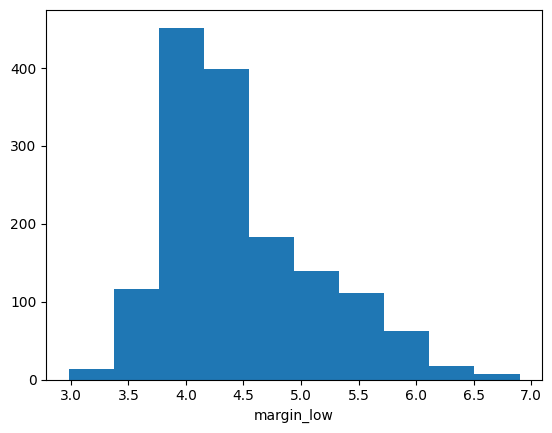

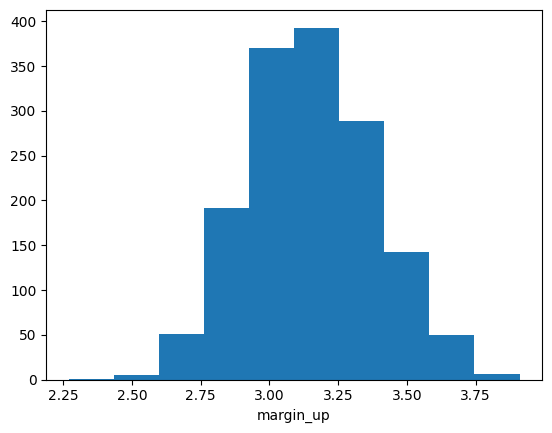

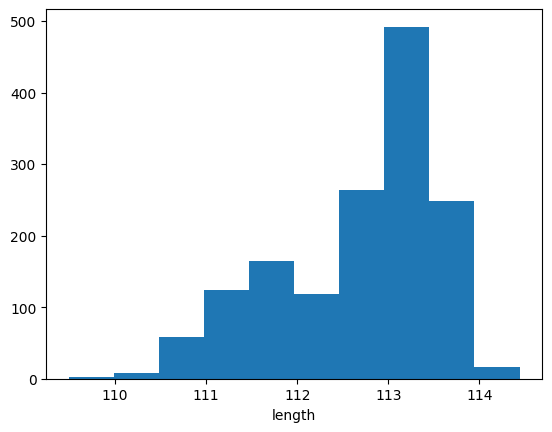

In [108]:
for i in df.columns:
    plt.hist(df[i])
    plt.xlabel(i)
    plt.show()

### Cần phải chuẩn hóa các giá trị do có sự chênh lệch giữa các cột margin và các cột còn lại

#### Không phát hiện các giá trị bất thường như số âm hoặc số quá lớn

<Axes: >

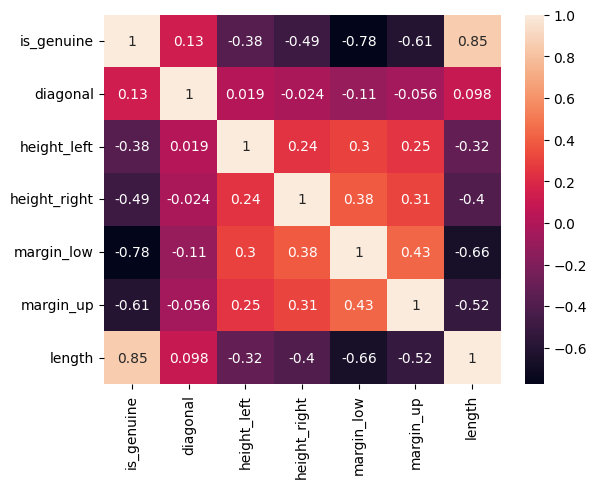

In [109]:
sns.heatmap(df.corr(),annot=True)

### Các features đều có mối quan hệ tương quan với nhau nên sẽ lấy toàn bộ các cột

In [110]:
from sklearn.preprocessing import MinMaxScaler

x = df.drop('is_genuine',axis =1)
x.info()
y = df['is_genuine']
scaler = MinMaxScaler()
x = scaler.fit_transform(x)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   diagonal      1500 non-null   float64
 1   height_left   1500 non-null   float64
 2   height_right  1500 non-null   float64
 3   margin_low    1500 non-null   float64
 4   margin_up     1500 non-null   float64
 5   length        1500 non-null   float64
dtypes: float64(6)
memory usage: 70.4 KB


In [111]:
oversample = RandomOverSampler(sampling_strategy='minority')
x_over,y_over = oversample.fit_resample(x, y)

In [112]:
x_over

array([[0.39086294, 0.98850575, 1.        , 0.39285714, 0.37804878,
        0.67474747],
       [0.21319797, 0.12643678, 0.3943662 , 0.20153061, 0.43902439,
        0.72727273],
       [0.83756345, 0.77011494, 0.31924883, 0.3622449 , 0.40853659,
        0.74141414],
       ...,
       [0.45685279, 0.6091954 , 0.38967136, 0.51530612, 0.70731707,
        0.52323232],
       [0.32994924, 0.59195402, 0.72769953, 0.59438776, 0.77439024,
        0.48484848],
       [0.72081218, 0.41954023, 0.72300469, 0.65816327, 0.64634146,
        0.24242424]])

In [113]:
x_train, x_test, y_train, y_test = train_test_split(x_over, y_over, test_size=0.2, random_state=42)

### khởi tạo model KNN và tìm ra tham số tốt nhất

In [114]:
param_grid = {'n_neighbors': range(1, 21)}
knn = KNeighborsClassifier()
grid_search = GridSearchCV(knn, param_grid, cv=5)
grid_search.fit(x_train, y_train)
best_k = grid_search.best_params_['n_neighbors']
best_accuracy = grid_search.best_score_

best_knn = KNeighborsClassifier(n_neighbors=best_k)
best_knn.fit(x_train, y_train)
print('model score is: ', best_knn.score(x_test, y_test)* 100 ,'%')

model score is:  98.75 %


In [122]:
print(classification_report(y_pred=best_knn.predict(x_test),y_true=y_test))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       201
           1       0.99      0.98      0.99       199

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



<Axes: >

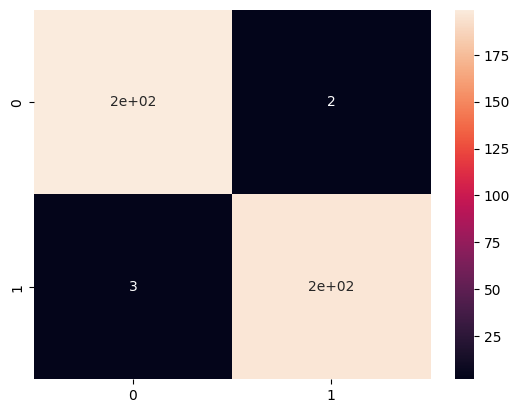

In [115]:
sns.heatmap(confusion_matrix(y_pred=best_knn.predict(x_test),y_true=y_test),annot=True)

### Khởi tạo model hồi quy Logistic và tìm ra tham số tốt nhất

In [116]:
lr = LogisticRegression()
best_lr = GridSearchCV(lr,param_grid={'penalty': ['l1','l2','elasticnet',None],
                                    'dual':[True,False],
                                    'C':[1,1.5,2,2.5,3,3.5,4,4.5,5],
                                    'solver':['lbfgs','liblinear','newton-cg','newton-cholesky','sag','saga'],
                                    'max_iter': [5,7]},cv=3,n_jobs=-1)
best_lr.fit(x_train,y_train)

GridSearchCV(cv=3, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5],
                         'dual': [True, False], 'max_iter': [5, 7],
                         'penalty': ['l1', 'l2', 'elasticnet', None],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg',
                                    'newton-cholesky', 'sag', 'saga']})

In [117]:
lr = LogisticRegression(**best_lr.best_params_)

In [118]:
lr.fit(x_train,y_train)

LogisticRegression(C=1, dual=True, max_iter=5, solver='liblinear')

In [119]:
pred = lr.predict(x_test)
print(classification_report(y_pred=pred,y_true=y_test))

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       201
           1       0.98      0.99      0.99       199

    accuracy                           0.99       400
   macro avg       0.99      0.99      0.99       400
weighted avg       0.99      0.99      0.99       400



<Axes: >

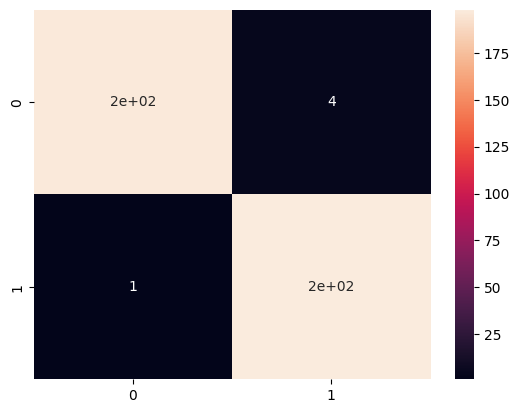

In [120]:
sns.heatmap(confusion_matrix(y_pred=pred,y_true=y_test),annot=True)

### Nhận xét:
Cả 2 model đều phù hợp để phân biệt tiền giả và tiền thật.
Tuy Nhiên nên ưu tiên sử dụng hồi quy Logistic để dự đoán do tỷ lệ dự đoán FN thấp hơn model KNN